# TV 正則化によるノイズ除去

In [1]:
import numpy as np
import matplotlib.pyplot as plt

$$\text{minimize}\ \sum_{i\in\mathcal{V}}d^2(u_i,f_i)+\lambda\sum_{i\in\mathcal{G}}\sum_{j\in\mathcal{N}^+}\varphi(d(u_i,u_j))\quad
\text{subject to}\ u_i\in S^{2}$$

In [2]:
import sys

sys.path += ['..', '../..']
from modules.total_variation.total_variation_sphere import ApproximatedTVonSphere as TVonSphere
from modules.total_variation.total_variation import TV

In [3]:
def normalize(img: np.ndarray) -> np.ndarray:
    res = img - np.min(img)
    res = res / np.max(res)
    return res

### 画像の読み込み

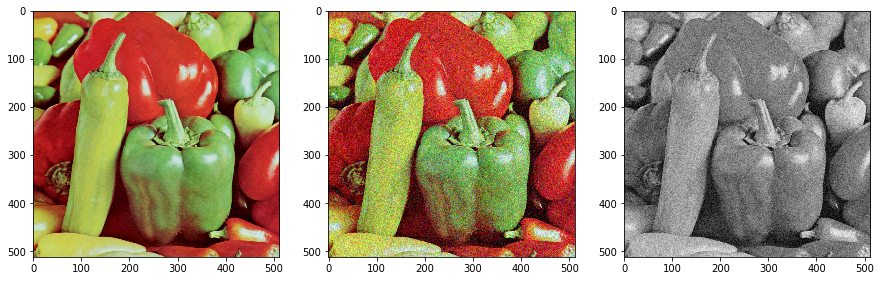

In [8]:
import cv2

img = cv2.cvtColor(cv2.imread('../../data/peppers.tiff'), cv2.COLOR_BGR2RGB) / 255.

# ノイズ
np.random.seed(0)
noise = np.random.normal(0, 0.1, img.shape)
noisy = np.clip(img + noise, 0, 1)
b_noisy = np.linalg.norm(noisy, axis=-1)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(img)
plt.grid(False)
plt.subplot(1,3,2)
plt.imshow(noisy)
plt.grid(False)
plt.subplot(1,3,3)
plt.imshow(b_noisy, cmap='gray')
plt.grid(False)
plt.show()

### TV 正則化

In [5]:
tv_b = TV(c=0.08, epsilon=1e-2, initial_step=.1, total_max_iter=10, max_iter=10, extended_output=True)
%prun Z = tv_b.transform(b_noisy, mask=None)

100%|██████████| 10/10 [00:01<00:00,  5.91it/s]

In [6]:
tv = TVonSphere(c=0.44, epsilon=1e-3, initial_step = .1, total_max_iter=10, max_iter=10, extended_output=True)
%prun X = tv.transform(noisy, mask=None)

100%|██████████| 10/10 [01:12<00:00,  7.29s/it]

### 実行結果
色情報

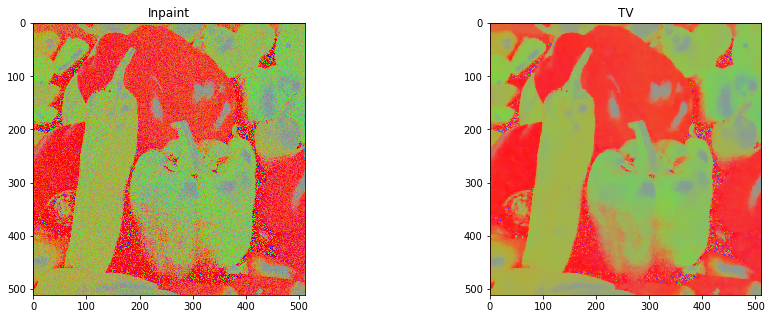

In [7]:
initialized = tv._inpaint(noisy)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(normalize(initialized))
plt.title('Inpaint')
plt.subplot(1,2,2)
plt.imshow(normalize(X))
plt.title('TV')
plt.show()

画像の復元

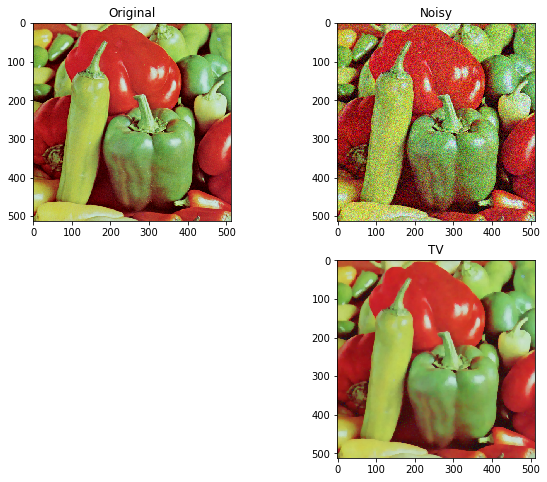

PSNR: 28.275530935791167


/Users/gotojunpei/Documents/ManifoldOptimization/venv/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.


In [9]:
from skimage.measure import compare_psnr

result = X * Z.reshape(*Z.shape, 1)

plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.imshow(img)
plt.title('Original')
plt.subplot(2,2,2)
plt.imshow(noisy)
plt.title('Noisy')
# plt.subplot(2,2,3)
# plt.imshow(inpainted)
# plt.title('Inpaint')
plt.subplot(2,2,4)
plt.imshow(result)
plt.title('TV')
plt.show()
print(f'PSNR: {compare_psnr(img, result)}')

目的関数値

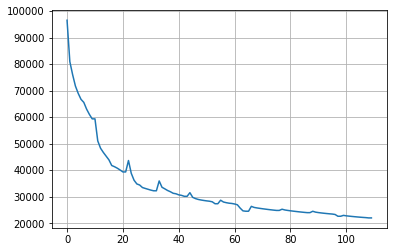

In [10]:
plt.plot(tv.f)
plt.grid()

In [11]:
np.save('../../data/peppers_a.npy', result)